# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

# Часть 1. SQL

Дана упрощенная схема базы данных:

![](https://drive.google.com/uc?export=view&id=1eZVg0OMLNh3Zn4Ss00oNw6KtcMYMTtdZ)

**telemetry** - таблица с телеметрией карьерных самосвалов следующего формата:

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 | 21:00:54 | 35 | 85,694 | 51.384 | 41.857 | 15.81 |

где
* id - номер записи в таблице
* objectid - идентификатор самосвала
* time - момент времени
* sensorid - идентификатор датчика
* value - значение, которое передал датчик
* lat, lon - координаты
* speed - текущая скорость самосвала

**objects** - таблица, в которой хранится информация о самосвалах:

| id | modelname | enterprise_id | created_at |
| :-: |:-: |:-: |:-: |
| 123 | БелАЗ-75131 | 4 | 01.01.2024 | 00:00:00 |

где
* id - идентификатор самосвала
* modelname - модель самосвала
* enterprise_id - идентификатор предприятия
* created_at - временная метка создания записи

**sensors** - таблица с описанием датчиков:

| id | name | tag | min_value | max_value |
| :-: |:-: |:-: |:-: | :-: |
| 35 | Вес | weight | 0 | 180 |

где
* id - идентификатор датчика
* name - наименование датчика
* tag - тег датчика
* min_value - минимальное допустимое значение датчика
* max_value - максимальное допустимое значение датчика


## Задание 1
Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75320” на предприятии с id = 6 выведет процент количества записей телеметрии, когда значение тега высоты (height) находилось в допустимых пределах, ![1ZadachaBD.png]()относительно всех записей по данному датчику за последние сутки.

In [ ]:
// postgres

create table if not exists sensors
(
	id serial primary key,
	name varchar(64) not null unique,
	tag varchar(100) not null unique,
	min_value int not null,
	max_value int not null
);

create table if not exists objects
(
	id serial primary key,
	modelname varchar(64) not null unique,
	enterprise_id int,
	created_at TIMESTAMP not null default now()
);

create table if not exists telemetry
(
	id serial primary key,
	objectId int not null,
	foreign key(objectId)
	references objects(id),
	time TIMESTAMP not null default now(),
	sensorId int not null,
	value int,
	foreign key(sensorId)
	references sensors(id),
	lat decimal(9, 3),
	lon decimal(9, 3),
	speed int not null
);

In [ ]:
WITH ValidHeightRecords AS (
    SELECT t.objectid,
        COUNT(*) AS valid_height_count
    FROM telemetry t
    JOIN objects o ON t.objectid = o.id
    JOIN sensors s ON t.sensorid = s.id
    WHERE
        o.modelname = 'БелАЗ-75320'
        AND o.enterprise_id = 6
        AND s.tag = 'height'
        AND t.time >= NOW() - INTERVAL '100 day'
        AND t.value BETWEEN s.min_value AND s.max_value
    GROUP BY t.objectid
)

-- Основной запрос
SELECT
    -- Идентификатор объекта (самосвала)
    t.objectId,

    -- Модель самосвала
    o.modelname,

    -- Общее количество записей для модели "БелАЗ-75320"
    SUM(CASE WHEN t.objectId = 2  THEN 1 ELSE 0 END) AS total_models,

    -- Процент допустимых записей относительно всех записей
    (SUM(CASE WHEN t.objectId = 2  THEN 1 ELSE 0 END) / COUNT(DISTINCT t.id) * 100.0 ) AS percentage_valid_height

FROM telemetry t
JOIN objects o ON t.objectid = o.id
LEFT JOIN ValidHeightRecords vhr ON t.id = vhr.objectid
WHERE o.enterprise_id = 6
    AND o.modelname = 'БелАЗ-75320'
GROUP BY t.objectId, o.modelname;

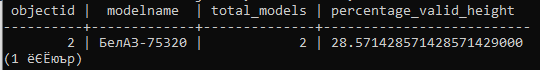

## Задание 2
Необходимо написать запрос, для вывода уникальных значений по датчику satenum (количество доступных спутников связи) для каждого самосвала с идентификатором из списка [34, 42, 99] за последние двое суток.

In [ ]:
SELECT
    -- Идентификатор объекта (самосвала)
    t.objectid,
    -- Модель самосвала
    o.modelname,
    -- Идентификатор датчика
    t.sensorid,
    -- Значение датчика satenum (количество доступных спутников связи)
    t.value AS satenum,
    -- Последнее время обновления
    MAX(t.time) AS last_update_time
FROM telemetry t
JOIN objects o ON t.objectid = o.id
WHERE
    -- Фильтрация по идентификаторам самосвалов из списка
    t.objectid IN (34, 42,99)

    -- Фильтрация по идентификатору датчика satenum
    AND t.sensorid = 5 -- 5 это идентификатор датчика satenum

    -- Фильтрация за последние двое суток
    AND t.time >= NOW() - INTERVAL '2 days'

-- Группировка по необходимым столбцам
GROUP BY t.objectid, o.modelname, t.sensorid, t.value
-- Сортировка по времени обновления в убывающем порядке
ORDER BY last_update_time DESC;

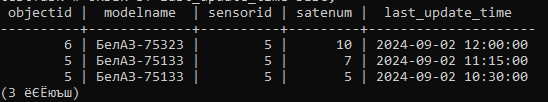

## Задание 3
В таблицу с телеметрией собираются данные с датчика уровня топлива в процентах (тег fuel_tank_level). В данной задаче будем считать, что самосвалы в течение последнего часа ездят непрерывно, а значит и уровень топлива постепенно снижается. Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75131” вернет 1, если был зафиксирован хоть один случай, когда между двумя последовательными временными точками изменение уровня топлива было более 5%, или вывести 0, если подобной аномалии не было.

In [ ]:
SELECT
-- Идентификатор объекта (самосвала)
	t.objectId,
  -- Идентификатор датчика
	t.sensorId,
  -- Модель самосвала
	o.modelname,
	CASE
		WHEN EXISTS (
      -- Подзапрос для проверки наличия аномалии в уровне топлива между последовательными временными точками
			SELECT 1
			FROM telemetry t1
			JOIN telemetry t2 on t1.time > t2.time and t1.time > t2.time
			WHERE t1.objectId = t2.objectId
			AND o.modelname = 'БелАЗ-75131'
			AND t1.sensorId = 4 -- 4 это тег fuel_tank_level

      -- Проверка изменения уровня топлива более чем на 5%
			AND ABS((t1.value - t2.value) * 100) > 5

      -- Условие, что изменение произошло в течение последнего часа
			AND t2.time - t1.time <= INTERVAL '1 hour'
		) THEN 1
		ELSE 0
	END AS fuel_anomaly_detected
FROM telemetry t
JOIN objects o on t.objectId = o.id
-- Фильтрация по модели "БелАЗ-75131"
WHERE o.modelname = 'БелАЗ-75131'
-- Группировка по необходимым столбцам
GROUP BY t.objectId, t.sensorId, o.modelname;

# 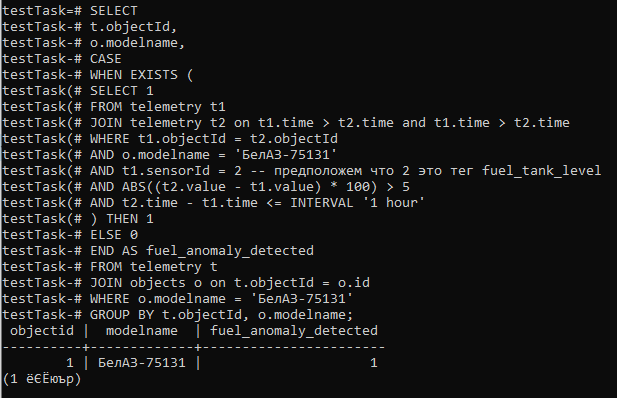





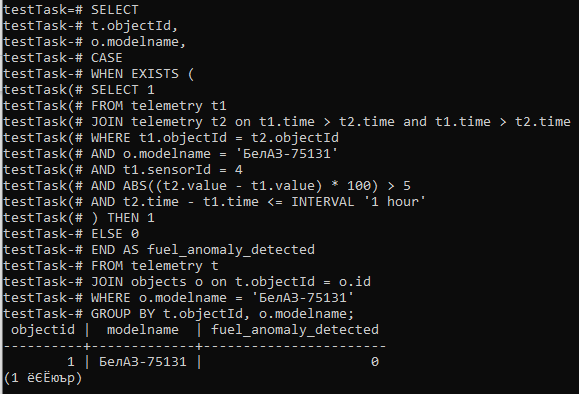

# Часть 2. Python

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
df = pd.read_parquet('/content/telemetry.parquet', engine='pyarrow')
df.head(5)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.00394,195.7,390.00,NaN,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.00000,280.0,0.00,0.000,8.00,0,0,NaN,NaN,1003657.0,216.0,2887.0,0,637716.857273,7.025866e+06
2,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.20000,228.0,66.85,778.000,5.00,0,0,NaN,NaN,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 14:16:39+07:00,63.343290,83.751773,16.80000,278.0,2.45,743.375,6.00,0,0,NaN,NaN,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.00000,70.9,17.00,NaN,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06


Предполагаю что df['w_fl'] является показателем указывающим на состояние самосвала
потому что показатель принимает бинарные значения [1, 0]
w_fl = 1 - самосвал находится в рабочем состояние
w_fl = 0 - самосвал не в рабочем состоянии или не выполняет действие

In [5]:
df['w_fl'].unique()

array([1, 0])

In [6]:
# чистка fuel_tank_level, weight_dynamic
# восполним Nan последним определенным значением

def fill_nan_with_last_valid_value(arr):
    valid_value = None
    for idx, value in enumerate(arr):
        if not np.isnan(value):
            valid_value = value
        else:
            arr[idx] = valid_value
    return arr

In [7]:
df['fuel_tank_level'] = fill_nan_with_last_valid_value(df['fuel_tank_level'])
df['weight_dynamic'] = fill_nan_with_last_valid_value(df['weight_dynamic'])

<ipython-input-6-2a8d85f57a13>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr[idx] = valid_value


In [8]:
# обработка df['engine_speed']
# заполним пустые значения в столбце средним значением
def fill_nan_with_mean(arr):
    mean_value = arr.mean()
    arr = arr.fillna(mean_value)
    return arr

In [9]:
df['engine_speed'] = fill_nan_with_mean(df['engine_speed'])

In [10]:
# обработка tripid, weight, driverid
df = df.dropna(subset=['tripid', 'weight', 'driverid'])

In [11]:
# Данные обработаны нет пустых значений
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425367 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              425367 non-null  int64                                
 1   time                  425367 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   425367 non-null  float64                              
 3   lon                   425367 non-null  float64                              
 4   speed                 425367 non-null  float64                              
 5   height                425367 non-null  float64                              
 6   fuel_cons             425367 non-null  float64                              
 7   engine_speed          425367 non-null  float64                              
 8   hdop                  425367 non-null  float64                  

Отображение карты карьера


In [12]:
min_longitude = df['lon'].min()
max_longitude = df['lon'].max()
min_latitude = df['lat'].min()
max_latitude = df['lat'].max()

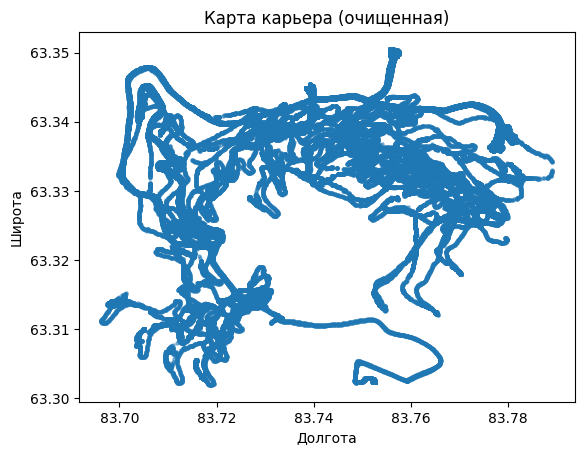

In [13]:
# Уберем выбросы по координатам
# берем только те записи которые находятся в
# пределах заданных границ
telemetry_cleaned = df[
    (df['lon'] > min_longitude) & (df['lon'] < max_longitude) &
    (df['lat'] > min_latitude) & (df['lat'] < max_latitude)
]

# Визуализация всех местоположений
plt.scatter(telemetry_cleaned['lon'], telemetry_cleaned['lat'], s=5, alpha=0.5)
plt.title('Карта карьера (очищенная)')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

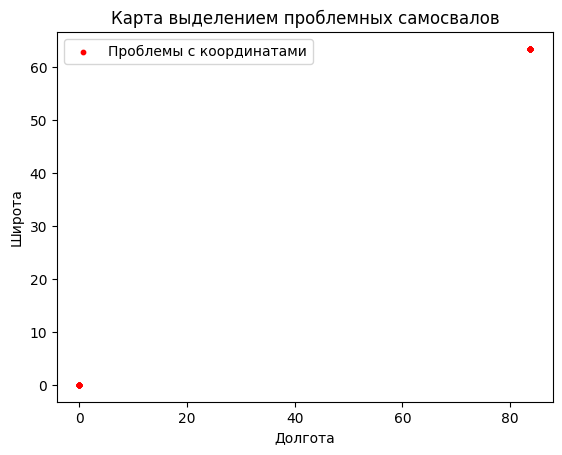

In [14]:
# Находим самосвалы с проблемами координат
problematic_trucks = df[df.index.isin(telemetry_cleaned.index)==False]

# Визуализация местоположения проблемных самосвалов
plt.scatter(problematic_trucks['lon'], problematic_trucks['lat'], s=10, color='red', label='Проблемы с координатами')
plt.title('Карта выделением проблемных самосвалов')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend()
plt.show()

# проблема этих данных заключается в том что они выходят за границы карьера
# эти данные являются аномальными

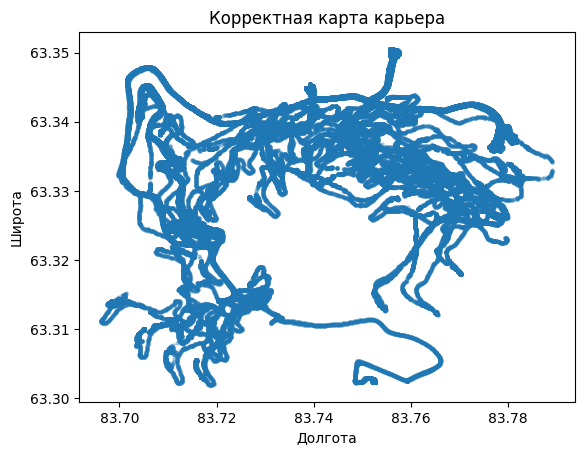

In [15]:
# визуализация корректной карты карьера
plt.scatter(telemetry_cleaned['lon'], telemetry_cleaned['lat'], s=5, alpha=0.3)
plt.title('Корректная карта карьера')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

In [16]:
# Препроцессинг данных для дальнейшего обучения
# Ранее все пустые значения были заполнены.
# Проведу стандартизацию (Z-нормализация)

# telemetry_cleaned.index = telemetry_cleaned['time']
# telemetry_cleaned = telemetry_cleaned.drop('time', axis=1)
# col = telemetry_cleaned.columns

# scaler_standard = StandardScaler()
# df_standardized = scaler_standard.fit_transform(telemetry_cleaned)
# df_standardized = pd.DataFrame(df_standardized, columns=col)
df_standardized = telemetry_cleaned

In [17]:
df_standardized.head(5)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.00394,195.7,390.00,1099.331509,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.00000,280.0,0.00,0.000000,8.00,0,0,60.0,216.0,1003657.0,216.0,2887.0,0,637716.857273,7.025866e+06
2,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.20000,228.0,66.85,778.000000,5.00,0,0,60.0,216.0,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 14:16:39+07:00,63.343290,83.751773,16.80000,278.0,2.45,743.375000,6.00,0,0,60.0,216.0,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.00000,70.9,17.00,1099.331509,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06


## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

In [18]:
# Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
parameters = ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height']

average_values = df_standardized.groupby('objectid')[parameters].mean()

average_values

,hdop,speed,engine_speed,DQ_vertical_bump,height
objectid,,,,,
1121,92.917078,9.917424,1099.331509,0.0,62.146886
1123,2.465518,16.343266,1099.331509,0.0,90.712864
1124,7.037529,12.791666,1135.849790,0.0,266.987452
1125,8.445052,13.658018,999.893772,0.0,264.804007
1126,7.584820,13.430823,1161.572864,0.0,262.754274


Построить гистограмму суммарных расстояний за каждый рейс

In [19]:
# у нас нету столбца расстояний поэтому необходимо его создать
df_standardized['distance'] = 0.0
df_standardized['lat_prev'] = df_standardized['lat'].shift()
df_standardized['lon_prev'] = df_standardized['lon'].shift()

def calculate_distance(row):
    coords1 = (row['lat'], row['lon'])
    coords2 = (row['lat_prev'], row['lon_prev'])

    if pd.notna(coords1[0]) and pd.notna(coords1[1]) and pd.notna(coords2[0]) and pd.notna(coords2[1]):
        return geodesic(coords1, coords2).meters
    else:
        return 0.0

df_standardized['distance'] = df_standardized.apply(calculate_distance, axis=1)

<ipython-input-19-c67e0b1148fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized['distance'] = 0.0
<ipython-input-19-c67e0b1148fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized['lat_prev'] = df_standardized['lat'].shift()
<ipython-input-19-c67e0b1148fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [20]:
df_standardized = df_standardized.drop(['lat_prev', 'lon_prev'], axis=1)

In [21]:
# создаем новый столбец который будет указывать суммарное расстояние за каждый рейс
df_standardized['total_distance'] = df_standardized.groupby('tripid')['distance'].transform('sum')

In [22]:
# Группировка по tripId и вычисление суммарных расстояний
total_distance_per_trip = df_standardized.groupby('tripid')['total_distance'].max()

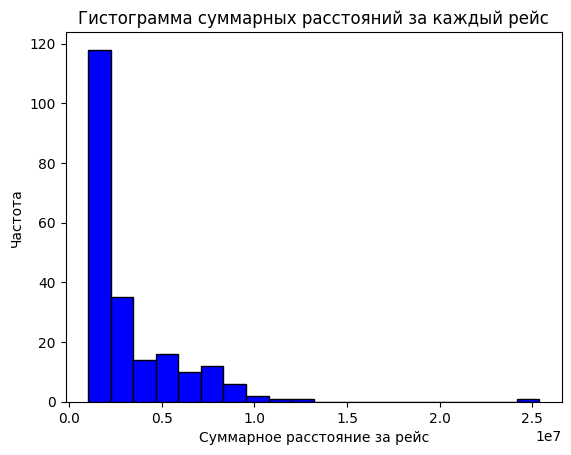

In [23]:
# Построение гистограммы
plt.hist(total_distance_per_trip, bins=20, color='blue', edgecolor='black')
plt.title('Гистограмма суммарных расстояний за каждый рейс')
plt.xlabel('Суммарное расстояние за рейс')
plt.ylabel('Частота')
plt.show()

Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)

In [24]:
df_standardized['time'] = pd.to_datetime(df['time'])
df_standardized['hour'] = df_standardized['time'].dt.hour

In [25]:
average_speed_per_hour = df_standardized.groupby(['objectid', 'hour'])['speed'].mean()
table = average_speed_per_hour.unstack()
table

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
objectid,,,,,,,,,,,,,,,,,,,,,
1121,18.466040,12.862556,8.235196,6.410654,13.865112,5.952499,7.554358,4.958597,7.181664,11.518727,...,6.155436,14.149674,9.615145,8.214560,13.732471,9.268503,9.241412,11.137591,8.723652,5.201494
1123,22.358631,18.714639,21.400921,11.881461,21.848800,15.330034,9.890281,11.867700,16.240954,15.558113,...,21.100563,17.448561,21.084696,11.919764,17.851139,8.152207,12.966198,15.429917,13.583356,4.830119
1124,19.359444,15.550194,17.290861,10.585278,14.064222,12.226444,14.285306,5.915778,11.248639,12.159278,...,11.643333,8.631111,9.319694,13.571139,13.014444,7.291333,19.083028,20.814111,15.509917,17.031289
1125,13.207333,17.689444,17.936111,16.948139,17.857639,15.306083,13.476444,11.308389,13.151722,12.256889,...,11.587000,9.888028,13.990139,13.970139,13.657278,6.877349,16.893639,20.637611,17.667306,12.841739
1126,17.664315,18.087889,15.322750,12.422889,17.381333,15.643083,14.816139,6.677806,13.042917,12.466944,...,11.875417,6.552028,14.732750,12.356639,12.940250,8.752861,17.955361,20.612500,15.397639,15.169694


In [26]:
average_speed_per_hour = df_standardized.groupby(['objectid', 'hour'])['speed'].mean()
table = average_speed_per_hour.unstack()
table

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
objectid,,,,,,,,,,,,,,,,,,,,,
1121,18.466040,12.862556,8.235196,6.410654,13.865112,5.952499,7.554358,4.958597,7.181664,11.518727,...,6.155436,14.149674,9.615145,8.214560,13.732471,9.268503,9.241412,11.137591,8.723652,5.201494
1123,22.358631,18.714639,21.400921,11.881461,21.848800,15.330034,9.890281,11.867700,16.240954,15.558113,...,21.100563,17.448561,21.084696,11.919764,17.851139,8.152207,12.966198,15.429917,13.583356,4.830119
1124,19.359444,15.550194,17.290861,10.585278,14.064222,12.226444,14.285306,5.915778,11.248639,12.159278,...,11.643333,8.631111,9.319694,13.571139,13.014444,7.291333,19.083028,20.814111,15.509917,17.031289
1125,13.207333,17.689444,17.936111,16.948139,17.857639,15.306083,13.476444,11.308389,13.151722,12.256889,...,11.587000,9.888028,13.990139,13.970139,13.657278,6.877349,16.893639,20.637611,17.667306,12.841739
1126,17.664315,18.087889,15.322750,12.422889,17.381333,15.643083,14.816139,6.677806,13.042917,12.466944,...,11.875417,6.552028,14.732750,12.356639,12.940250,8.752861,17.955361,20.612500,15.397639,15.169694


Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).

In [27]:
# выбор по одному рейсу для каждого самосвала
unique_trips = df_standardized.drop_duplicates(subset=['objectid', 'tripid'])

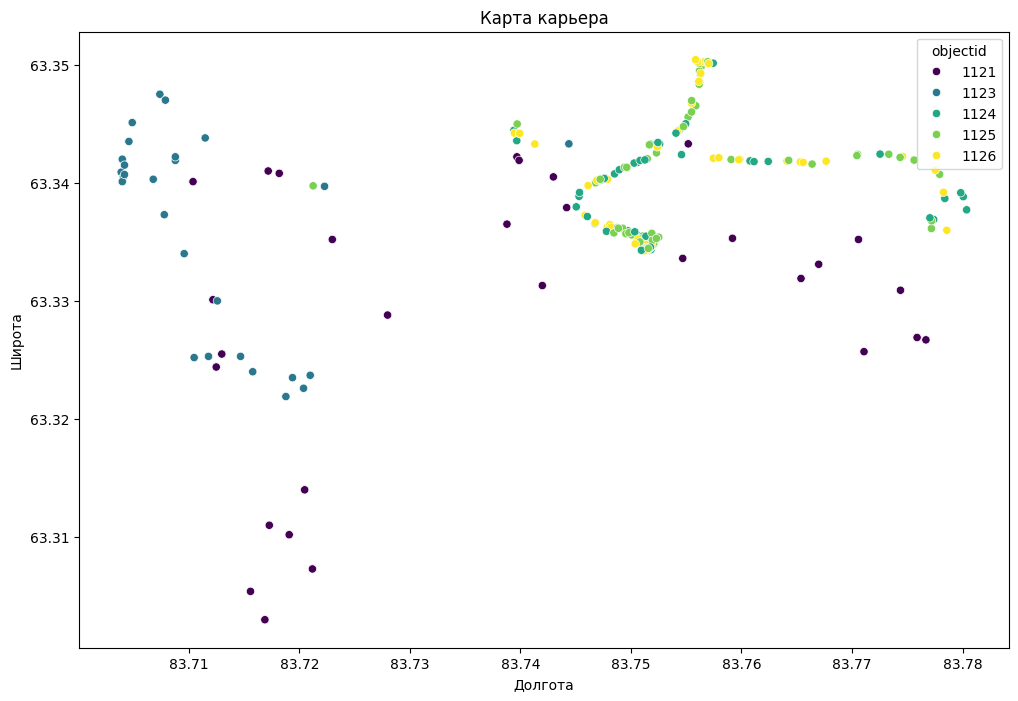

In [28]:
# рисуем карту карьера
plt.figure(figsize=(12, 8))
sns.scatterplot(x=unique_trips['lon'], y=unique_trips['lat'], hue=unique_trips['objectid'], data=unique_trips, palette='viridis', legend='full')
plt.title('Карта карьера')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

<Figure size 1200x800 with 0 Axes>

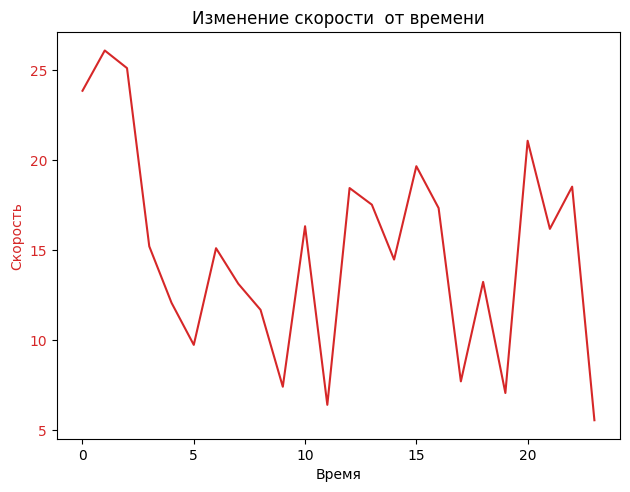

In [29]:
gp = unique_trips.groupby('hour')[['speed', 'height']].mean()

# нарисовать график изменения скорости от времени и высоты
plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Время')
ax1.set_ylabel('Скорость', color=color)
ax1.plot(gp.index, gp['speed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Изменение скорости  от времени')
plt.show()

<Figure size 1200x800 with 0 Axes>

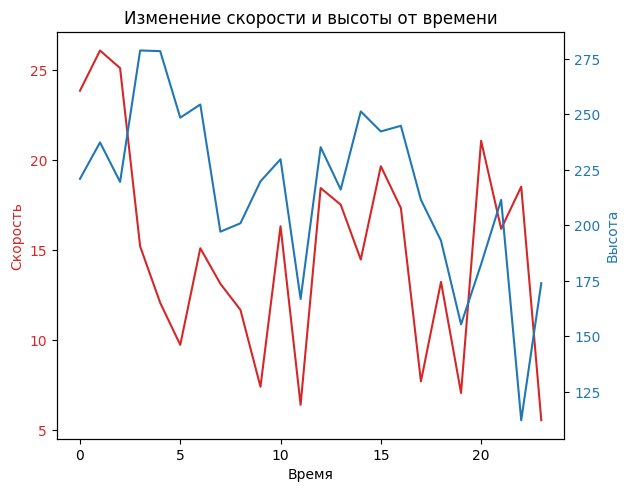

In [30]:
gp = unique_trips.groupby('hour')[['speed', 'height']].mean()

# нарисовать график изменения скорости от времени и высоты
plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Время')
ax1.set_ylabel('Скорость', color=color)
ax1.plot(gp.index, gp['speed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Создаем вторую ось y
color = 'tab:blue'
ax2.set_ylabel('Высота', color=color)
ax2.plot(gp.index, gp['height'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Изменение скорости и высоты от времени')
plt.show()

<Figure size 1200x800 with 0 Axes>

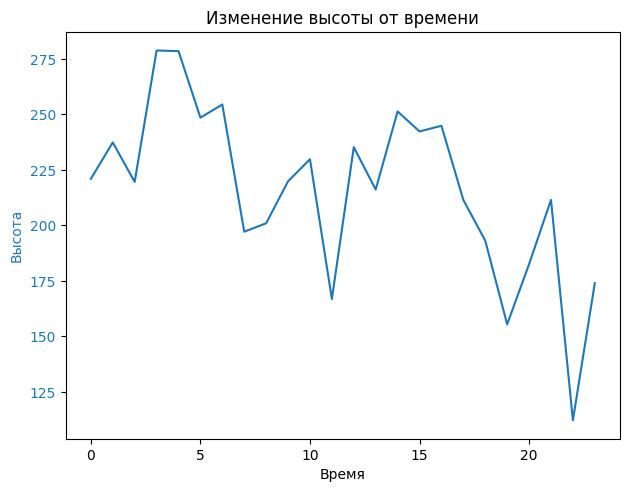

In [31]:
gp = unique_trips.groupby('hour')[['height']].mean()

plt.figure(figsize=(12, 8))
fig, ax = plt.subplots()

color = 'tab:blue'
ax.set_xlabel('Время')
ax.set_ylabel('Высота', color=color)
ax.plot(gp.index, gp['height'], color=color)
ax.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Изменение высоты от времени')
plt.show()

Присоединить данные погоды к данным телеметрии

In [32]:
weather_dataset= pd.read_parquet('/content/weather_hourly.parquet', engine='pyarrow')
weather_dataset.head(5)

,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,2023-11-07 20:00:00+00:00,0.0,0.0,-13.27,-20.02,-17.59,67.0,1027.0,3.48,8.91,60.0,100.0,10000.0,clouds,0,0,1
1,2023-11-08 06:00:00+00:00,0.0,0.0,-9.27,-15.79,-16.07,54.0,1020.0,4.13,8.20,71.0,100.0,10000.0,clouds,0,0,1
2,2023-11-07 18:00:00+00:00,0.0,0.0,-13.27,-20.10,-17.59,67.0,1028.0,3.55,8.92,62.0,95.0,10000.0,clouds,0,0,1
3,2023-11-07 16:00:00+00:00,0.0,0.0,-13.27,-19.67,-17.44,68.0,1030.0,3.18,7.71,61.0,94.0,10000.0,clouds,0,0,1
4,2023-11-07 11:00:00+00:00,0.0,0.0,-10.27,-16.63,-14.37,69.0,1033.0,3.72,9.60,64.0,65.0,10000.0,clouds,0,0,1


In [ ]:
df_standardized['time'] = pd.to_datetime(df_standardized['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
weather_dataset['time'] = weather_dataset['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [33]:
df_merged = pd.merge(df_standardized, weather_dataset, on='time', how='left')

## Задание 3

**Обучить модель для предсказания значений скорости самосвала (колонка speed)**
* Можно (и даже нужно) генерировать дополнительные фичи.
* Выполнить необходимые (на Ваш взгляд) преобразования датасета.
* Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики
* Обучить несколько моделей и сравнить их. Интерпретировать результаты.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
# разделение данных на признаки
X = df_merged[['objectid', 'lat', 'lat', 'lon', 'height', 'fuel_cons', 'engine_speed', 'hdop', 'DQ_vertical_bump',
        'accelerator_position', 'fuel_tank_level', 'weight_dynamic', 'tripid', 'weight', 'driverid', 'w_fl',
        'distance', 'total_distance', 'precipIntensity', 'temperature', 'apparentTemperature', 'dewPoint',
               'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'visibility',
              'rain', 'snow', 'no_weather_info']]
y = df_merged['speed']

In [40]:
# дополнительные фичи

# мгновенное изменение веса
X['weight_change'] = X['weight_dynamic'].diff()
# средний вес за предыдущие 5 временных точек
X['avg_weight_prev'] = X['weight_dynamic'].shift().rolling(window=5).mean()

<ipython-input-40-79f090806a4f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['weight_change'] = X['weight_dynamic'].diff()
<ipython-input-40-79f090806a4f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['avg_weight_prev'] = X['weight_dynamic'].shift().rolling(window=5).mean()


In [41]:
# разделение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# обработка пропущенных значений
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Для задачи регресии где нужно предсказывать непрерывные значения я выбрал MSE.MSE измеряет среднеквадротичное отклонение предсказанных значений от действительных. Это позволяет легче интерпритировать насколько предсказанные
значения к настоящим.
Кроме того MSE чувствителен к большим отклонениям.

In [43]:
# создание и обучение модели
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# прогнозирование на тестовом наборе
y_pred = model.predict(X_test_scaled)

# оценка качества модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 37.004870700291875


In [44]:
# создание и обучение линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# создание и обучение градиентного бустинга
boosting_model = GradientBoostingRegressor(random_state=42)
boosting_model.fit(X_train_scaled, y_train)

# прогнозирование на тестовом наборе для других моделей
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_boosting = boosting_model.predict(X_test_scaled)

# оценка качества для других моделей
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_boosting = mean_squared_error(y_test, y_pred_boosting)

print(f'MSE Linear Regression: {mse_linear}')
print(f'MSE Gradient Boosting: {mse_boosting}')

MSE Linear Regression: 142.74672917540977
MSE Gradient Boosting: 77.22698774783505
